# Depression detector by favourite Spotify Playlist

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import joblib
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
!pip  install pyarrow --quiet

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, KFold, train_test_split

!pip install spotipy --quiet
from array import *
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

!pip install livelossplot --quiet
from keras.models import model_from_json
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

import math

es = EarlyStopping(monitor = 'loss', patience = 3)
#------------------------------------------------------------------------------------------------------------------------------#
client_id= '4e8a6305a50f41208b67294e49f5fd05'
client_secret='7b4f7d653d3b4c99b5dec2eda8a76f5e'
##Spotify Developer account provide client id and secret for usag in coding

#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#user input playlist url
playlist_URL = input("Enter playlist URL here:")
print("--------------------------------------------------------------------------------------------------------------------")

playlist_URI = playlist_URL.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

track_data = []

Valence = []
Danceability = []
Energy = []
Key = []
Liveness = []
Loudness = []
Speechiness = []
Tempo = []

for track in sp.playlist_tracks(playlist_URI)["items"]:
    #Track name
    track_name = track["track"]["name"]
    #print(track_name)
    
    #URI    
    track_uri = track["track"]["uri"]
    track_data = sp.audio_features(track_uri)
    #Store data into array
    Valence.append(track_data[0]['valence'])
    Danceability.append(track_data[0]['danceability'])
    Energy.append(track_data[0]['energy'])
    Key.append(track_data[0]['key'])
    Liveness.append(track_data[0]['liveness'])
    Loudness.append(track_data[0]['loudness'])
    Speechiness.append(track_data[0]['speechiness'])
    Tempo.append(track_data[0]['tempo'])
    
 
print("--------------------------------------------------------------------------------------------------------------------")

dataset=pd.read_csv("musicmood.csv")

y = dataset[['mood']]
x = dataset[['valence','danceability','energy','key','liveness','loudness','speechiness','tempo']]

x2 = MinMaxScaler().fit_transform(x)

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

x_train, x_test, y_train, y_test = train_test_split(x,encoded_y,test_size = 0.2, random_state = 15)

target = pd.DataFrame({'mood':dataset['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],
                                                                                                          ascending=True)

X_Train = x_train.copy()
Y_Train = y_train.copy()

X_Test = x_test.copy()
Y_Test = y_test.copy()

numericColumns = x_train.columns.tolist()

scaler = MinMaxScaler()
scaler.fit(dataset[numericColumns])
X_Train[numericColumns] = scaler.transform(X_Train[numericColumns])
X_Test[numericColumns] = scaler.transform(X_Test[numericColumns])

Y_Train = pd.DataFrame(Y_Train)
Y_Train.columns = ['mood']
Y_Test = pd.DataFrame(Y_Test)
Y_Test.columns = ['mood']

X_Train.to_parquet('X_Train.parquet')
X_Test.to_parquet('X_Test.parquet')

pd.DataFrame(Y_Train).to_parquet('Y_Train.parquet')
pd.DataFrame(Y_Test).to_parquet('Y_Test.parquet')

# Load processed data from disk
X_Train = pd.read_parquet('X_Train.parquet')
X_Test = pd.read_parquet('X_Test.parquet')

Y_Train = pd.read_parquet('Y_Train.parquet')
Y_Test = pd.read_parquet('Y_Test.parquet')
#------------------------------------------------------------------------------------------------------------------------------#
#Create the model
def base_model():
    model = Sequential()
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='softmax'))
    model.add(keras.layers.Dense(2, activation="sigmoid"))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

def predict_mood(valence, danceability, energy, key, liveness, loudness, speechiness, tempo):
    new_input = {'valence':valence,'danceability':danceability,'energy':energy,'key':key,
                 'liveness' :liveness,'loudness':loudness,'speechiness':speechiness,'tempo':tempo}
    new_input_df = pd.DataFrame([new_input])
    new_input_df[numericColumns] = scaler.transform(new_input_df[numericColumns])
    X_new_input = new_input_df[numericColumns]

    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=20,batch_size=250,
                                                                             verbose=0,callbacks=[es]))])
    #Fit the Pipeline
    pip.fit(x,encoded_y)
    #Predict the features of the song
    results = pip.predict(X_new_input)

    mood = np.array(target['mood'][target['encode']==int(results)])
    return mood[0]

#------------------------------------------------------------------------------------------------------------------------------#
#For reprinting loading progress
_last_print_len = 0 
def reprint(msg,msg2,msg3, finish=False): 
    global _last_print_len 
     
    print(' '*_last_print_len, end='\r') 
     
    if finish: 
        end = '\n' 
        _last_print_len = 0 
    else: 
        end = '\r' 
        _last_print_len = len(msg) 
     
    print(msg,msg2,msg3, end=end) 
#------------------------------------------------------------------------------------------------------------------------------#
Song_mood = []
song_name = []
i = 0
j = len(Valence)
print("Please wait we are processing your data...")
for track in sp.playlist_tracks(playlist_URI)["items"]:
    songmood = predict_mood(Valence[i], Danceability[i], Energy[i], Key[i],Liveness[i], Loudness[i], Speechiness[i], Tempo[i])
    Song_mood.append(songmood)
    song_name.append(track["track"]["name"])
    i = i + 1
    reprint("Proccessing",math.trunc((i/j)*100),"% data")
print("proccessing complete!  ")    
#calculate percentage of sad song in the playlist
total = i+1
sad = 0
notsad = 0
for a,b in zip(song_name, Song_mood):
    print(a,':',b)
    if b=='notsad':
        notsad = notsad + 1
    if b=='sad':
        sad = sad + 1
        
percentage = (sad / i)*100
sadness_prob = sad/i
print("Percentage of sadness based on your favourite song preference :",percentage, "%")

stress_level = int(input("From scale 1 - 10, how stress are you?"))
if stress_level<=10 and stress_level>=1 :
    stress_prob = stress_level/10
else:
    print("Out of range given!")
print("Probability of stress:", stress_prob)

depression_prob = sadness_prob * stress_prob


print("Based on calculation, you have probability of ", depression_prob," to be depressed.")
if depression_prob >= 0.75 :
    print("You are having severe depression!")
    print("Please contact 1-800-82-0066 or email to info.miasa@gmail.com to recieve help and aid.")
    print("Talk more to people")
elif depression_prob >= 0.35 and depression_prob <0.75 :
    print("You are having mild depression.")
    print("If you insist, you can contact 1-800-82-0066 or email to info.miasa@gmail.com to get more information about deperssion")
    print("Eat healthy food and find good vibes")
else:
    print("Your depression type is normal")
    print("Continue having good mental health by doing what you like.")

ModuleNotFoundError: No module named 'matplotlib'

# Data checking section :

In [4]:
dataset.isnull().sum().sort_values(ascending = False)/dataset.shape[0]

uri                 0.0
acousticness        0.0
valence             0.0
danceability        0.0
energy              0.0
key                 0.0
instrumentalness    0.0
liveness            0.0
loudness            0.0
speechiness         0.0
tempo               0.0
duration            0.0
mood                0.0
dtype: float64

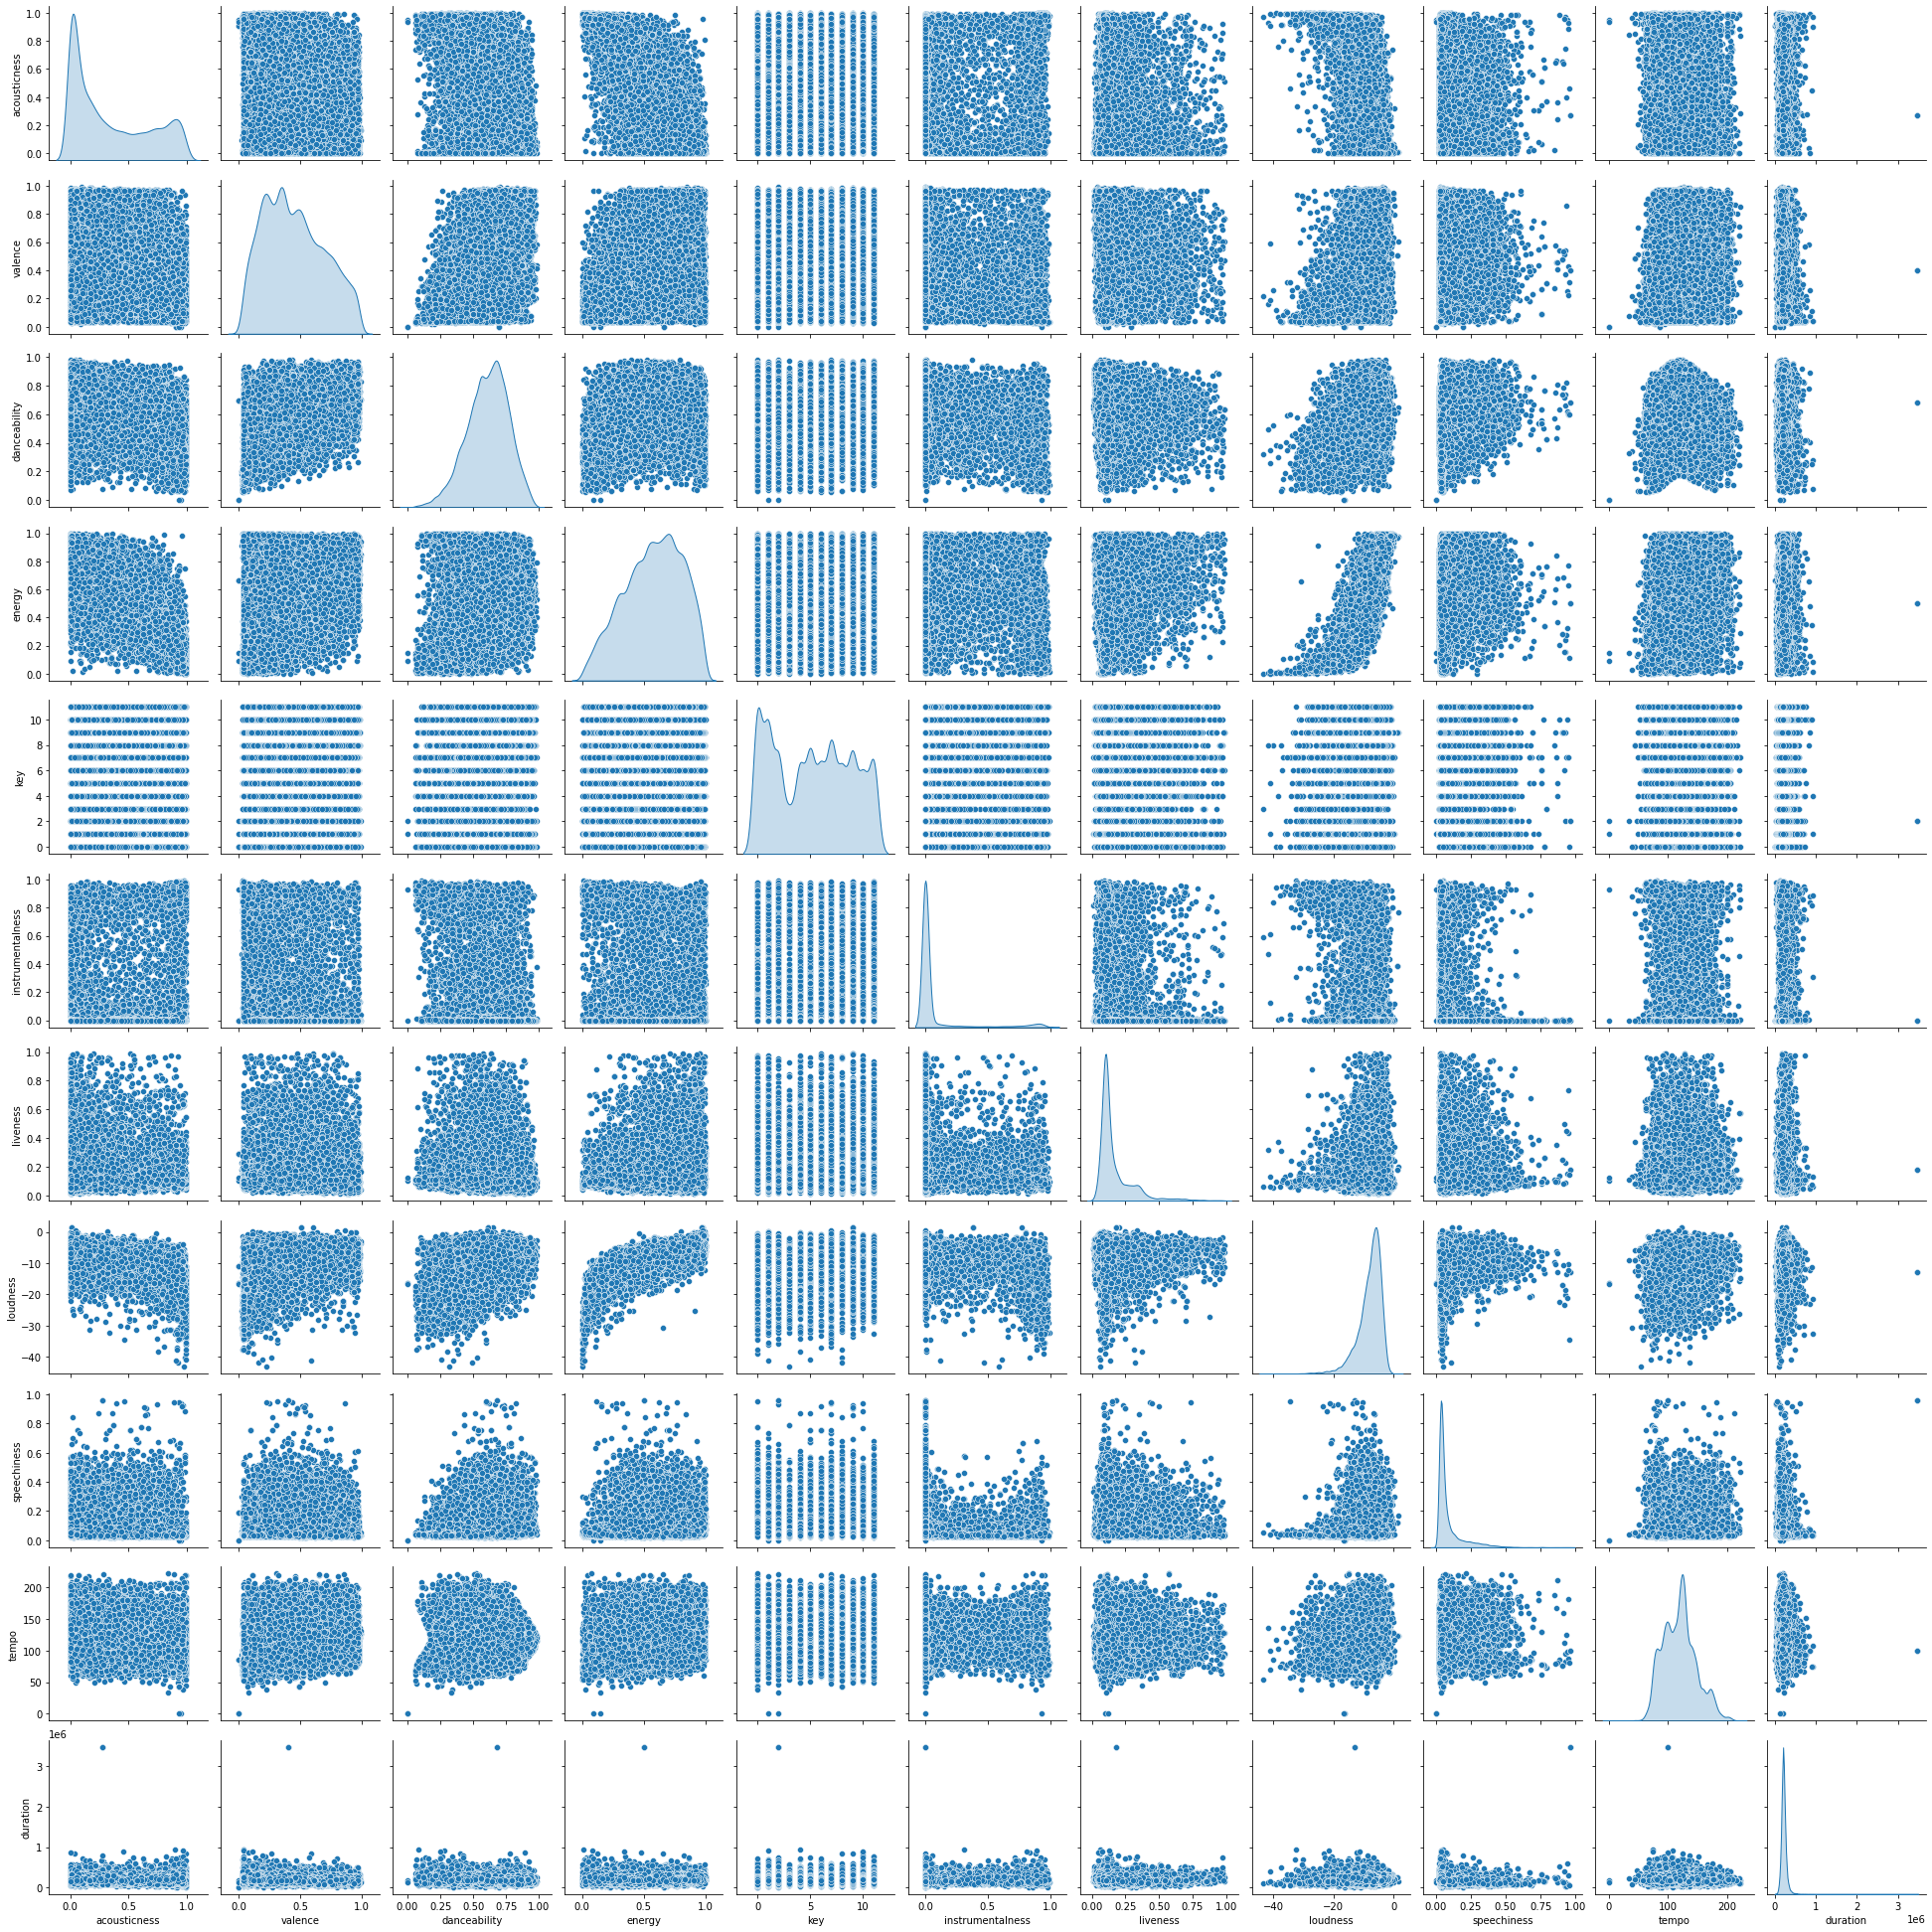

In [115]:
sns.pairplot(data = dataset, diag_kind = 'kde')

<function matplotlib.pyplot.show(close=None, block=None)>

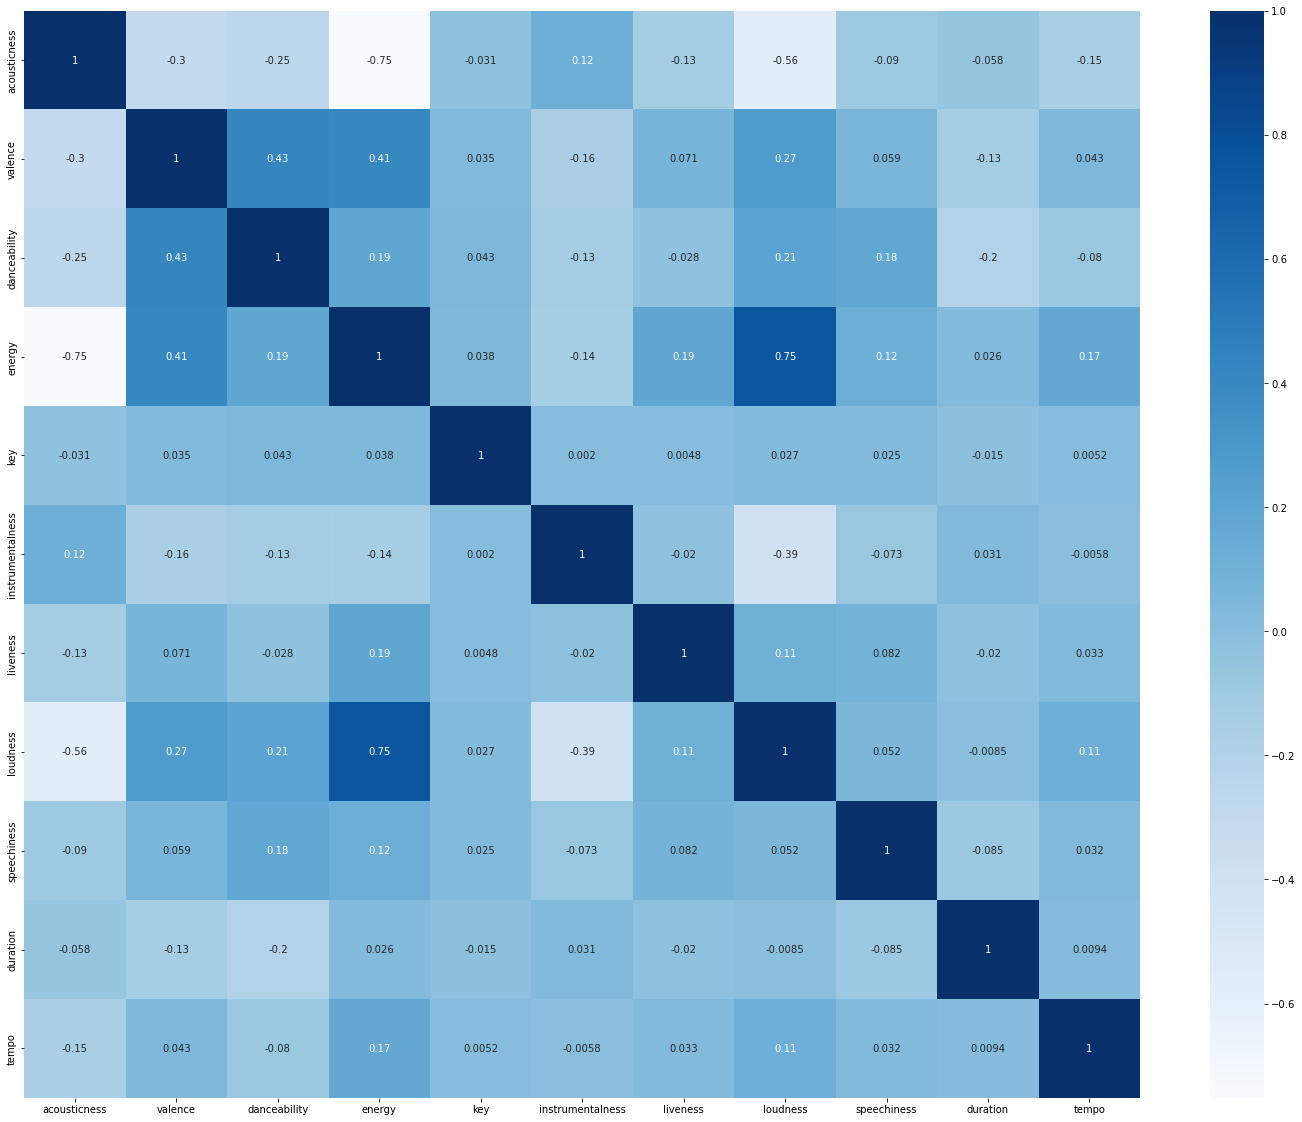

In [116]:
plt.figure(figsize = (25,20))
sns.heatmap(dataset[['acousticness','valence','danceability','energy','key','instrumentalness',
                     'liveness','loudness','speechiness','duration','tempo','mood']].corr(),cmap='Blues', annot = True)

plt.show

# KFold Section :

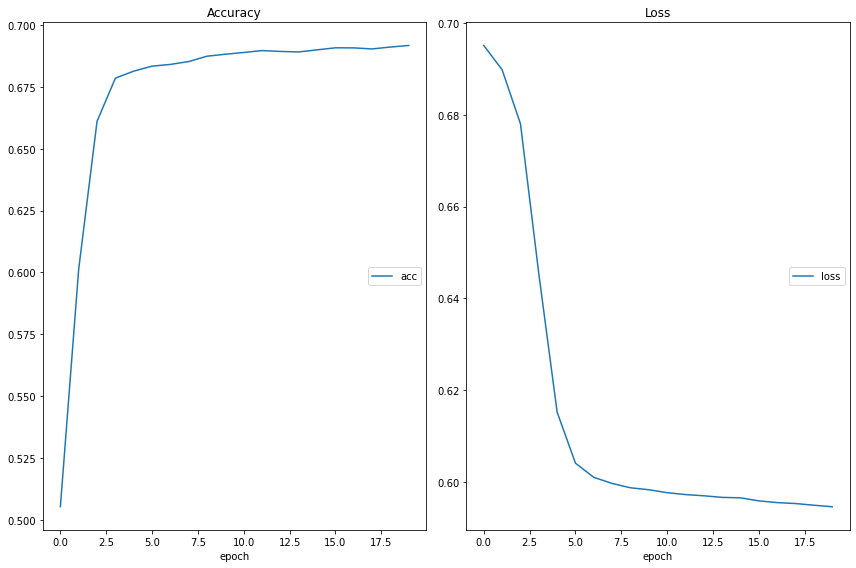

Accuracy
	acc              	 (min:    0.505, max:    0.692, cur:    0.692)
Loss
	loss             	 (min:    0.595, max:    0.695, cur:    0.595)
Baseline: 69.05% (0.78%)


In [89]:
es = EarlyStopping(monitor = 'loss', patience = 3)

estimator = KerasClassifier(build_fn=base_model,epochs=20,batch_size=250,verbose=0,callbacks=[PlotLossesKeras(), es])

kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,x2,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

# Model accuracy and saving :

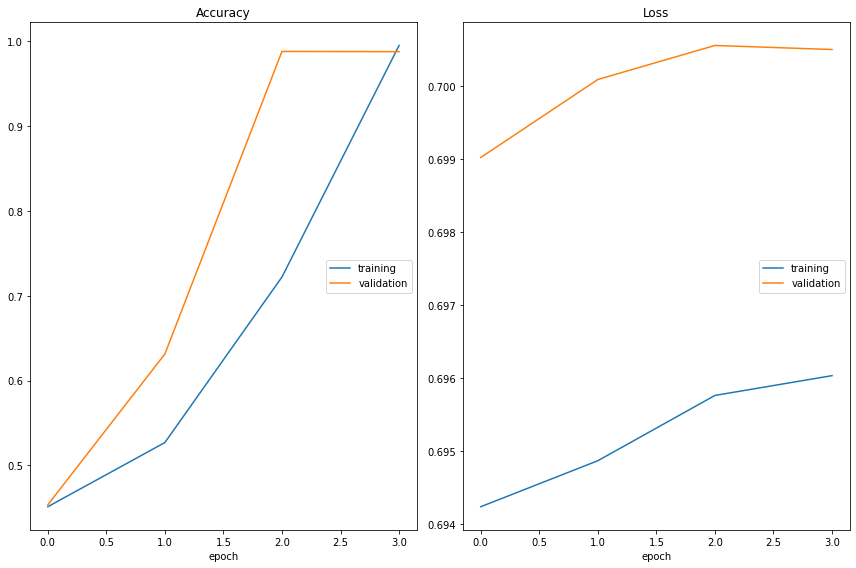

Accuracy
	training         	 (min:    0.451, max:    0.995, cur:    0.995)
	validation       	 (min:    0.454, max:    0.988, cur:    0.988)
Loss
	training         	 (min:    0.694, max:    0.696, cur:    0.696)
	validation       	 (min:    0.699, max:    0.701, cur:    0.701)
Model accuracy: 98.93
Saved model to disk
Loaded model from disk
Model accuracy: 98.93


In [141]:
es = EarlyStopping(monitor = 'val_loss', patience = 3)

model = Sequential()
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.add(keras.layers.Dense(2, activation="sigmoid"))
#Compile the model using sigmoid loss function and adam optim
model.compile(loss='categorical_crossentropy',optimizer='adam',
             metrics=['accuracy'])
model.fit(X_Train.values,Y_Train.values, epochs=20,batch_size=250, validation_data=(X_Test.values, Y_Test.values), 
          callbacks=[PlotLossesKeras(), es], verbose=0)
callbacks=[PlotLossesKeras()]
_, accuracy = model.evaluate(X_Train.values,Y_Train.values)    #testing
print("Model accuracy: %.2f"% (accuracy*100))   


# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy',optimizer='adam',
             metrics=['accuracy'])
_, accuracy2 = loaded_model.evaluate(X_Train.values,Y_Train.values)    #testing
print("Model accuracy: %.2f"% (accuracy2*100))   

# Training Section :

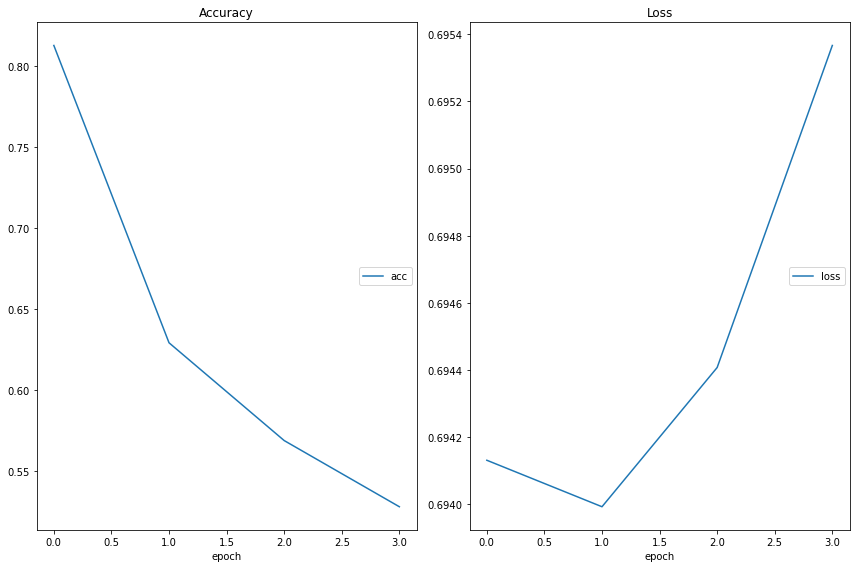

Accuracy
	acc              	 (min:    0.528, max:    0.813, cur:    0.528)
Loss
	loss             	 (min:    0.694, max:    0.695, cur:    0.695)
Training model accuracy: 98.93


In [142]:
estimator.fit(X_Train.values,Y_Train)


_, accuracytrain = model.evaluate(X_Train.values,Y_Train.values)    #testing
print("Training model accuracy: %.2f"% (accuracytrain*100))  

# Testing Section :

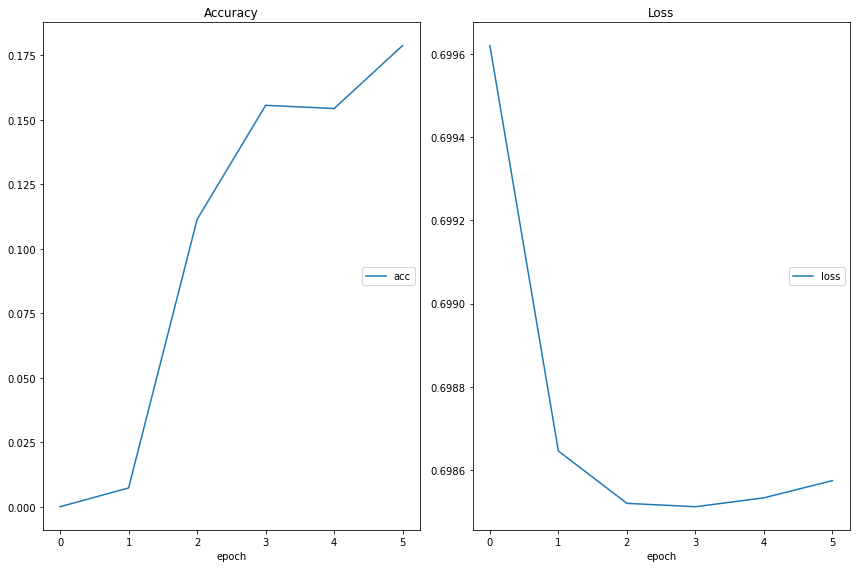

Accuracy
	acc              	 (min:    0.000, max:    0.179, cur:    0.179)
Loss
	loss             	 (min:    0.699, max:    0.700, cur:    0.699)
Test model accuracy: 98.79


In [143]:
estimator.fit(X_Test.values,Y_Test)


_, accuracytest = model.evaluate(X_Test.values,Y_Test.values)    #testing
print("Test model accuracy: %.2f"% (accuracytest*100)) 